In [1]:
%matplotlib inline

import ast
import json
import urllib
import urllib2
from cStringIO import StringIO
import pandas as pd
import geopandas as gpd
import mplleaflet
import numpy as np
import matplotlib.pyplot as plt

SQL_SOURCE = 'https://htv210.cartodb.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

## Task 1 

In [2]:
dischargeQuery = '''
SELECT facility_id, count(facility_id)

FROM nyc_discharge_2013
WHERE ccs_diagnosis_description = 'ASTHMA'
GROUP BY facility_id
ORDER BY count DESC
'''
dischargeStream = queryCartoDB(dischargeQuery, format='CSV')
discharge       = pd.read_csv(dischargeStream)
discharge.head()

,facility_id,count
0,1172,1878
1,1169,1786
2,1301,1057
3,1165,920
4,1178,890


In [3]:
facilityQuery = '''
SELECT *

FROM nyc_facilities

WHERE facility_id in (1172, 1169, 1301,1165, 1178)
'''
facilityStream = queryCartoDB(facilityQuery, format='GeoJSON')
facilityData   = json.loads(facilityStream.read())
facilities     = gpd.GeoDataFrame.from_features(facilityData['features'])
facilities.head()

,cartodb_id,cooperator_address,cooperator_address_2,cooperator_city,cooperator_name,cooperator_state,cooperator_zip_code,description,facility_address_1,facility_address_2,...,operator_address_1,operator_address_2,operator_city,operator_name,operator_state,operator_zip_code,ownership_type,regional_office,regional_office_id,short_description
0,624,,,,,New York,NaN,Hospital,1400 Pelham Parkway,,...,125 Worth Street,,New York,New York City Health and Hospital Corporation,New York,10013,Municipality,Metropolitan Area Regional Office - New York City,5,HOSP
1,627,111 East 210th Street,,Bronx,Montefiore Medical Center,New York,10467,Hospital,111 East 210th Street,,...,111 East 210th Street,,Bronx,"Montefiore Health System, Inc",New York,10467,Not for Profit Corporation,Metropolitan Area Regional Office - New York City,5,HOSP
2,628,,,,,New York,NaN,Hospital,234 East 149th Street,,...,125 Worth Street,,New York,New York City Health and Hospital Corporation,New York,10013,Municipality,Metropolitan Area Regional Office - New York City,5,HOSP
3,631,,,,,New York,NaN,Hospital,1650 Grand Concourse,,...,1276 Fulton Avenue,,Bronx,Bronx Lebanon Hospital Center Inc,New York,10456,Not for Profit Corporation,Metropolitan Area Regional Office - New York City,5,HOSP
4,696,,,,,New York,NaN,Hospital,451 Clarkson Avenue,,...,125 Worth Street,,New York,New York City Health and Hospital Corporation,New York,10013,Municipality,Metropolitan Area Regional Office - New York City,5,HOSP


In [4]:
facilities.crs = {'init': 'epsg:4326', 'no_defs': True}
facilities = facilities.to_crs(epsg=2263)

In [5]:
facilities['geometry']

0    POINT (1026645.436320588 251684.2060465284)
1     POINT (1017278.463616514 259890.221163824)
2    POINT (1005228.021716391 237182.1691768789)
3    POINT (1008724.037560453 246639.2619315821)
4    POINT (999760.5456509431 178215.3371727151)
Name: geometry, dtype: object

In [6]:
dots   = facilities.set_geometry(facilities.geometry.buffer(2000))
f, ax = plt.subplots(1, figsize=(5,5))
dots.plot()
mplleaflet.display(crs=dots.crs)

In [7]:
zip_fa= '''
SELECT *
FROM nyc_facilities

'''
zip_fad = queryCartoDB(zip_fa, format='GeoJSON')
zip_fad   = json.loads(zip_fad .read())
zip_fad1 = gpd.GeoDataFrame.from_features(zip_fad ['features'])
zip_fad1.head()

,cartodb_id,cooperator_address,cooperator_address_2,cooperator_city,cooperator_name,cooperator_state,cooperator_zip_code,description,facility_address_1,facility_address_2,...,operator_address_1,operator_address_2,operator_city,operator_name,operator_state,operator_zip_code,ownership_type,regional_office,regional_office_id,short_description
0,2106,,,,,New York,NaN,Diagnostic and Treatment Center,1110 Pennsylvania Avenue,,...,1110 Pennsylvania Avenue,,Brooklyn,PALA Community Care LLC,New York,11207,LLC,Metropolitan Area Regional Office - New York City,5,DTC
1,2311,,,,,New York,NaN,Diagnostic and Treatment Center,468 Lafayette Avenue,,...,468 Lafayette Avenue,,Brooklyn,"Medcare, LLC",New York,11205,LLC,Metropolitan Area Regional Office - New York City,5,DTC
2,643,,,,,New York,NaN,Diagnostic and Treatment Center,1776 Clay Avenue,,...,1776 Clay Avenue,,Bronx,P R O M E S A Inc,New York,10457,Not for Profit Corporation,Metropolitan Area Regional Office - New York City,5,DTC
3,805,,,,,New York,NaN,Residential Health Care Facility - SNF,214 West Houston Street,,...,"120 Broadway, Suite 2840",,New York,Village Center for Care,New York,10271,Not for Profit Corporation,Metropolitan Area Regional Office - New York City,5,NH
4,1903,,,,,New York,NaN,Diagnostic and Treatment Center,2781 Third Ave,,...,2781 Third Avenue,,Bronx,Third Avenue Open MRI Inc,New York,10455,Business Corporation,Metropolitan Area Regional Office - New York City,5,DTC


## Task 2 

In [8]:
facilities['facility_zip_code']

0    10461
1    10467
2    10451
3    10457
4    11203
Name: facility_zip_code, dtype: int64

In [9]:
zipcodeQuery = '''
SELECT *
FROM nyc_zipcode_highway

WHERE zipcode in (10461,10467,10451,10457,11203)
'''
zipcodeStream = queryCartoDB(zipcodeQuery, format='GeoJSON')
zipcodeData   = json.loads(zipcodeStream.read())
zipcode      = gpd.GeoDataFrame.from_features(zipcodeData['features'])
zipcode.head()

,cartodb_id,geometry,highway_length,zipcode
0,106,"(POLYGON ((-73.863293 40.89529, -73.862875 40....",19.172015,10467
1,111,"(POLYGON ((-73.931681 40.807955, -73.931704 40...",7.914185,10451
2,123,"(POLYGON ((-73.897516 40.856183, -73.896533000...",5.017199,10457
3,125,"(POLYGON ((-73.82612399999999 40.834214, -73.8...",18.102258,10461
4,195,"(POLYGON ((-73.942503 40.638965, -73.943986 40...",2.212840,11203


In [10]:
zipcodes = zipcode[['highway_length','zipcode','geometry']]

In [11]:
f_data = facilities[['facility_name','facility_zip_code']]
f_data.columns = ['name','zipcode']
f_data

,name,zipcode
0,Jacobi Medical Center,10461
1,Montefiore Medical Center - Henry & Lucy Moses...,10467
2,Lincoln Medical & Mental Health Center,10451
3,Bronx-Lebanon Hospital Center - Concourse Divi...,10457
4,Kings County Hospital Center,11203


In [12]:
z_data = pd.merge(f_data,zipcodes)
z_data.head()

,name,zipcode,highway_length,geometry
0,Jacobi Medical Center,10461,18.102258,"(POLYGON ((-73.82612399999999 40.834214, -73.8..."
1,Montefiore Medical Center - Henry & Lucy Moses...,10467,19.172015,"(POLYGON ((-73.863293 40.89529, -73.862875 40...."
2,Lincoln Medical & Mental Health Center,10451,7.914185,"(POLYGON ((-73.931681 40.807955, -73.931704 40..."
3,Bronx-Lebanon Hospital Center - Concourse Divi...,10457,5.017199,"(POLYGON ((-73.897516 40.856183, -73.896533000..."
4,Kings County Hospital Center,11203,2.212840,"(POLYGON ((-73.942503 40.638965, -73.943986 40..."


In [13]:
z_data = gpd.GeoDataFrame(z_data)

In [14]:
z_data.crs = {'init': 'epsg:4326', 'no_defs': True}
z_data.to_crs(epsg=2263)

,name,zipcode,highway_length,geometry
0,Jacobi Medical Center,10461,18.102258,(POLYGON ((1032365.388388703 243251.7094464547...
1,Montefiore Medical Center - Henry & Lucy Moses...,10467,19.172015,(POLYGON ((1022045.174324712 265485.8146390664...
2,Lincoln Medical & Mental Health Center,10451,7.914185,"(POLYGON ((1003162.871453055 233644.226793992,..."
3,Bronx-Lebanon Hospital Center - Concourse Divi...,10457,5.017199,(POLYGON ((1012600.268767681 251224.6751115753...
4,Kings County Hospital Center,11203,2.212840,(POLYGON ((1000207.410375923 172073.7932331467...


In [15]:
zipcodeQuery = '''
SELECT *
FROM nyc_zipcode_highway

'''
zipcodeStream = queryCartoDB(zipcodeQuery, format='GeoJSON')
zipcodeData   = json.loads(zipcodeStream.read())
zipcode      = gpd.GeoDataFrame.from_features(zipcodeData['features'])
zipcode.head()

,cartodb_id,geometry,highway_length,zipcode
0,1,"(POLYGON ((-74.194287 40.608911, -74.194929 40...",23.486470,10314
1,2,"(POLYGON ((-73.980886 40.75927, -73.9804259999...",0.000000,10112
2,3,"(POLYGON ((-74.011674 40.709687, -74.012646 40...",1.447405,10048
3,4,"(POLYGON ((-73.97282 40.75587, -73.973276 40.7...",0.000000,10171
4,5,"(POLYGON ((-73.973735 40.754619, -73.975352 40...",0.000000,10172


In [16]:
zipcode.crs = {'init': 'epsg:4326', 'no_defs': True}
zipcode = zipcode.to_crs(epsg=2263)
zipcode.head()

,cartodb_id,geometry,highway_length,zipcode
0,1,(POLYGON ((930304.3783042837 161178.9118938052...,23.486470,10314
1,2,(POLYGON ((989545.2338407208 215899.8262413288...,0.000000,10112
2,3,(POLYGON ((981013.4939667572 197834.8189977061...,1.447405,10048
3,4,(POLYGON ((991780.1768988252 214661.6858826231...,0.000000,10171
4,5,(POLYGON ((991526.8142341244 214205.8286250296...,0.000000,10172


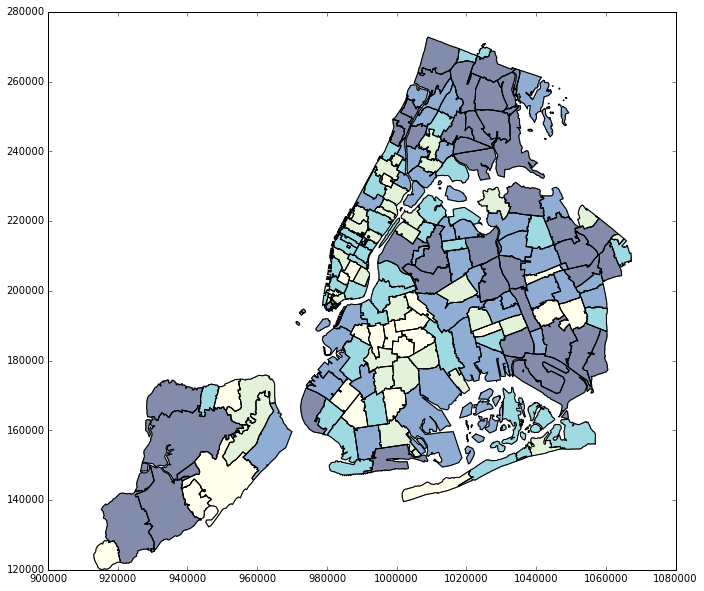

In [17]:
f = plt.figure(figsize=(15,10))
zipcode.plot(column ='highway_length',scheme='QUANTILES',colormap='YlGnBu')

## yellow is less highway length area, blue is more highway length area

In [18]:
zipcode.head()

,cartodb_id,geometry,highway_length,zipcode
0,1,(POLYGON ((930304.3783042837 161178.9118938052...,23.486470,10314
1,2,(POLYGON ((989545.2338407208 215899.8262413288...,0.000000,10112
2,3,(POLYGON ((981013.4939667572 197834.8189977061...,1.447405,10048
3,4,(POLYGON ((991780.1768988252 214661.6858826231...,0.000000,10171
4,5,(POLYGON ((991526.8142341244 214205.8286250296...,0.000000,10172


## Task 3 - Task 5

### Task 4 
- I chose top 5 nearest park for each zipcode to calculate green space 

In [19]:
gs = gpd.GeoDataFrame.from_file('DPR_ParksProperties_001/DPR_ParksProperties_001.shp')

In [20]:
gs.head()

,BOROUGH,GISPROPNUM,LOCATION,NYS_ASSEMB,NYS_SENATE,SHAPE_STAr,SHAPE_STLe,SIGNNAME,TYPECATEGO,US_CONGRES,WATERFRONT,geometry
0,Q,Q104,"Queensboro Bridge, 41 Rd., 40 Ave. bet. The Ea...",37,12,903579.125015,7376.271660,Queensbridge Park,Community Park,12,Yes,"(POLYGON ((998639.7287544757 214672.844326064,..."
1,X,X253,City Island Ave bet. Centre St. and Winter St.,82,34,263831.264191,2635.610175,Ambrosini Field,Recreation Field/Courts,14,Yes,"POLYGON ((1044445.201119721 246876.5331993997,..."
2,Q,Q494,"Beach 116 St., Ocean Promenade",23,15,6547.116425,403.979314,Flight 587 Memorial Park,Triangle/Plaza,5,Yes,"POLYGON ((1029700.335596383 149921.5630677193,..."
3,X,X245,E 180 St bet. the Bronx River and Devoe Av,87,33,20232.591873,582.832405,River Garden,Garden,15,Yes,"POLYGON ((1018493.260897726 246060.4564194828,..."
4,Q,Q465,Vernon Blvd. bet. Broadway and 30 Dr.,37,12,199700.239243,3014.558046,Socrates Sculpture Park,Neighborhood Park,12,Yes,"(POLYGON ((1001911.54078038 219553.4448010623,..."


In [21]:
zipcode['cp'] = zipcode['geometry'].centroid
gs['cp'] = gs['geometry'].centroid

In [22]:
gs_x = []
gs_y = []
for i in range(len(gs)):
    gs_x.append(gs['cp'][i].x)
    gs_y.append(gs['cp'][i].y)

In [23]:
dic = {'x':gs_x,'y':gs_y,'area':gs['SHAPE_STAr']}
gs_df = pd.DataFrame(dic)
gs_df.head()

,area,x,y
0,903579.125015,998605.106596,214637.547414
1,263831.264191,1044180.735226,247025.950043
2,6547.116425,1029761.679323,149883.063671
3,20232.591873,1018385.157537,246047.305651
4,199700.239243,1001858.043841,219421.536305


In [24]:
zp_x = []
zp_y = []
for i in range(len(zipcode)):
    zp_x.append(zipcode['cp'][i].x)
    zp_y.append(zipcode['cp'][i].y)

In [25]:
dic = {'x':zp_x,'y':zp_y,'zipcode':zipcode['zipcode']}
zp_df = pd.DataFrame(dic)

In [26]:
zp_df.head()

,x,y,zipcode
0,939028.086368,157049.816099,10314
1,989882.629998,215862.553930,10112
2,980807.697791,198555.421131,10048
3,991492.507838,214672.291375,10171
4,991366.109232,214444.171199,10172


In [27]:
def cal_dis(x1,y1,x2,y2):
    diff_x = x2-x1 
    diff_y = y2-y1
    dis = np.sqrt((diff_x)**2 + (diff_y)**2)
    return  dis

In [28]:
cal_dis(zp_df.x[0],zp_df.y[0],gs_df.x[0],gs_df.y[0])

82859.930829351084

In [29]:
gs_list = []
for i in range(len(zp_df)):
    dis_area = []
    for j in range(len(gs_df)):
        xy = cal_dis(zp_df.x[i],zp_df.y[i],gs_df.x[j],gs_df.y[j])
        re_area = gs_df['area'][j] / xy
        dis_area.append((xy,re_area))
    a = dis_area
    a.sort()
    b = a[0:5]
    total = b[0][1] + b [1][1] + b[2][1] + b[3][1] + b[4][1]

    gs_list.append(total)

In [30]:
zipcode.head()

,cartodb_id,geometry,highway_length,zipcode,cp
0,1,(POLYGON ((930304.3783042837 161178.9118938052...,23.486470,10314,POINT (939028.0863684642 157049.8160994551)
1,2,(POLYGON ((989545.2338407208 215899.8262413288...,0.000000,10112,POINT (989882.6299983194 215862.5539302718)
2,3,(POLYGON ((981013.4939667572 197834.8189977061...,1.447405,10048,POINT (980807.6977910449 198555.4211312696)
3,4,(POLYGON ((991780.1768988252 214661.6858826231...,0.000000,10171,POINT (991492.5078376996 214672.2913748862)
4,5,(POLYGON ((991526.8142341244 214205.8286250296...,0.000000,10172,POINT (991366.109232271 214444.1711985988)


In [31]:
dic = {'geometry':zipcode['geometry'],'highway_length':zipcode['highway_length'],
       'zipcode':zipcode['zipcode'],'re_area':gs_list}
dataset = pd.DataFrame(dic)
dataset.head()

,geometry,highway_length,re_area,zipcode
0,(POLYGON ((930304.3783042837 161178.9118938052...,23.486470,12498.309511,10314
1,(POLYGON ((989545.2338407208 215899.8262413288...,0.000000,232.403224,10112
2,(POLYGON ((981013.4939667572 197834.8189977061...,1.447405,1288.375432,10048
3,(POLYGON ((991780.1768988252 214661.6858826231...,0.000000,98.415515,10171
4,(POLYGON ((991526.8142341244 214205.8286250296...,0.000000,256.075672,10172


In [32]:
g_data  = gpd.GeoDataFrame(dataset)

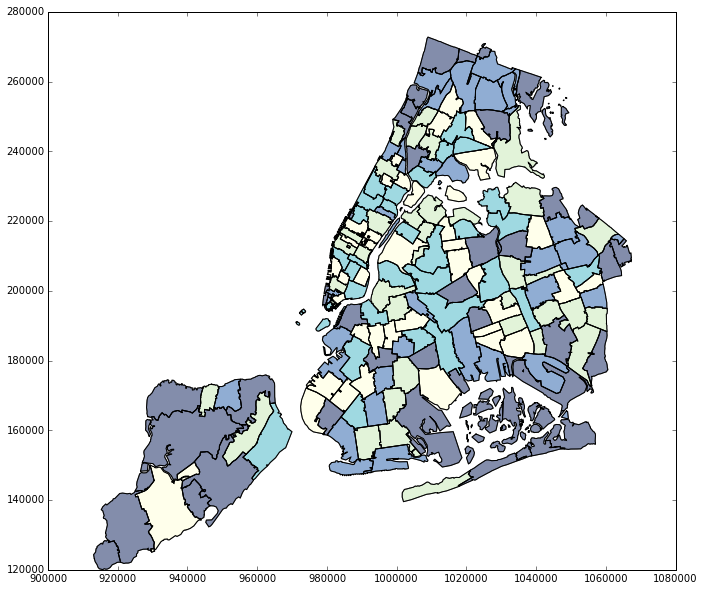

In [33]:
f = plt.figure(figsize=(15,10))
g_data.plot(column ='re_area',scheme='QUANTILES',colormap='YlGnBu')

## yellow is less green space area, blue is more green space area.

### Extra : Task 5 -1 
- I chose indoor air quality, air quality and dirty conditions as valid complaint types (Because I think only air quality affect asthma.)
- I used indoor air quality as feature and normalized by total count.

In [34]:
SQL_SOURCE = 'https://lz1335.cartodb.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [35]:
tooQuery = '''
SELECT incident_zip,count(cartodb_id)
FROM table_2013
WHERE complaint_type = 'Indoor Air Quality'

GROUP BY incident_zip

'''
threeoo = queryCartoDB(tooQuery, format='CSV')
three       = pd.read_csv(threeoo)
three.head()

,incident_zip,count
0,NaN,5
1,11385,31
2,10314,15
3,10454,15
4,11691,23


In [36]:
three = three.dropna()
three.columns = ['zipcode','indoor']
three.head()

,zipcode,indoor
1,11385,31
2,10314,15
3,10454,15
4,11691,23
5,11241,1


In [37]:
tooQuery = '''
SELECT incident_zip,count(cartodb_id)
FROM table_2013
GROUP BY incident_zip

'''
threeoo = queryCartoDB(tooQuery, format='CSV')
total_three       = pd.read_csv(threeoo)
total_three.head()

,incident_zip,count
0,NaN,1503
1,11385,526
2,10314,309
3,10454,102
4,11691,165


In [38]:
total_three = total_three.dropna()
total_three.columns = ['zipcode','total']
total_three.head()

,zipcode,total
1,11385,526
2,10314,309
3,10454,102
4,11691,165
5,11241,1


In [39]:
indoor_three = pd.merge(three,total_three)
indoor_three.head()

,zipcode,indoor,total
0,11385,31,526
1,10314,15,309
2,10454,15,102
3,11691,23,165
4,11241,1,1


In [40]:
indoor_three['indoor_rate'] = indoor_three['indoor'] / indoor_three['total']

In [41]:
indoor = pd.merge(zipcode,indoor_three)
indoor.head()

,cartodb_id,geometry,highway_length,zipcode,cp,indoor,total,indoor_rate
0,1,(POLYGON ((930304.3783042837 161178.9118938052...,23.486470,10314,POINT (939028.0863684642 157049.8160994551),15,309,0.048544
1,7,(POLYGON ((990945.5268556802 216318.4261852367...,0.000000,10103,POINT (990436.141769278 216450.0857468668),1,1,1.000000
2,8,"(POLYGON ((1035584.184422478 207025.202050885,...",8.713778,11365,POINT (1041744.45393489 208529.9484450314),4,167,0.023952
3,9,"(POLYGON ((1017328.055436699 190773.09629767, ...",9.737716,11208,POINT (1019960.692429493 183255.0732698567),27,416,0.064904
4,10,(POLYGON ((1065257.440439317 212635.2141156869...,4.827112,11004,POINT (1064262.40714042 211126.7499980467),22,84,0.261905


In [42]:
indoor1 = indoor[['geometry','indoor_rate']]
indoor1 = gpd.GeoDataFrame(indoor1)

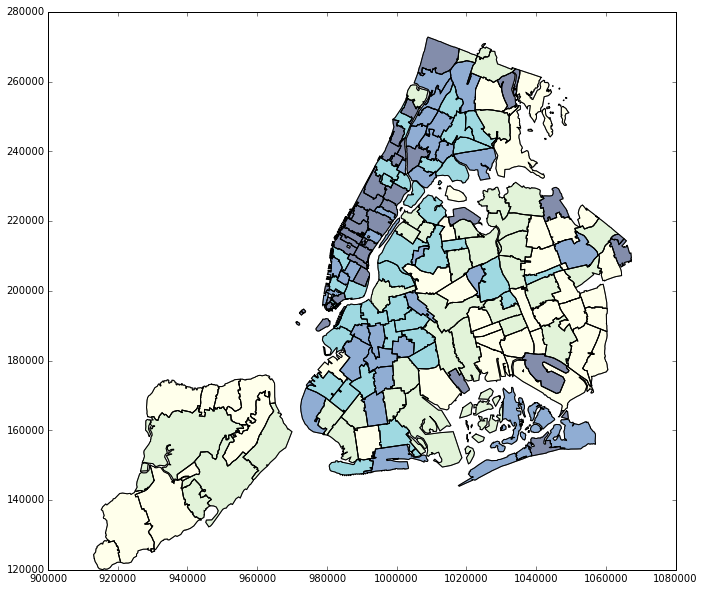

In [43]:
f = plt.figure(figsize=(15,10))
indoor1.plot(column ='indoor_rate',scheme='QUANTILES',categorical=False,colormap='YlGnBu')

## Comment
Yellow is less call rate area, blue is highly call rate area.

## Task 6-1 fitting with highway_length and green space

In [44]:
zip_fad = pd.merge(zip_fad1,discharge)

In [45]:
zip_fad11 = zip_fad[['facility_zip_code','count']]

In [46]:
zip_fad11.head()

,facility_zip_code,count
0,11213,248
1,11203,489
2,10461,920
3,10466,492
4,10467,1786


In [47]:
zip_gp = zip_fad11.groupby('facility_zip_code').sum()
zip_gp.to_csv('fad.csv')
zip_gp= pd.read_csv('fad.csv')

In [48]:
zip_gp[zip_gp['facility_zip_code'] == 11213]

,facility_zip_code,count
24,11213,248


In [49]:
zip_gp= zip_gp[['facility_zip_code','count']]
zip_gp.columns = ['zipcode','asthma']
zip_gp.head()

,zipcode,asthma
0,10003,559
1,10016,312
2,10019,289
3,10021,562
4,10025,346


In [50]:
facilities['facility_zip_code']

0    10461
1    10467
2    10451
3    10457
4    11203
Name: facility_zip_code, dtype: int64

In [51]:
zip_gp = zip_gp[(zip_gp['zipcode']==10461 )| (zip_gp['zipcode']==10467 )| (zip_gp['zipcode']==10451) |(zip_gp['zipcode']==10457 )| (zip_gp['zipcode']==11203)]

In [52]:
zip_gp.head()

,zipcode,asthma
13,10451,1878
14,10457,1580
15,10461,1343
17,10467,1996
21,11203,1780


In [53]:
dataset2 = dataset[(dataset['zipcode']==10461 )| (dataset['zipcode']==10467 )| (dataset['zipcode']==10451) |(dataset['zipcode']==10457 )| (dataset['zipcode']==11203) ]

In [54]:
dataset2

,geometry,highway_length,re_area,zipcode
105,(POLYGON ((1022045.174324712 265485.8146390664...,19.172015,626.829219,10467
110,"(POLYGON ((1003162.871453055 233644.226793992,...",7.914185,925.561765,10451
122,(POLYGON ((1012600.268767681 251224.6751115753...,5.017199,107.886430,10457
124,(POLYGON ((1032365.388388703 243251.7094464547...,18.102258,2490.266013,10461
194,(POLYGON ((1000207.410375923 172073.7932331467...,2.212840,126.180895,11203


In [55]:
dataset3 = facilities[['facility_id','facility_zip_code']]
dataset3.columns = ['facility_id','zipcode']
dataset3

,facility_id,zipcode
0,1165,10461
1,1169,10467
2,1172,10451
3,1178,10457
4,1301,11203


In [56]:
lm_df = pd.merge(dataset2,zip_gp)
lm_df.head()

,geometry,highway_length,re_area,zipcode,asthma
0,(POLYGON ((1022045.174324712 265485.8146390664...,19.172015,626.829219,10467,1996
1,"(POLYGON ((1003162.871453055 233644.226793992,...",7.914185,925.561765,10451,1878
2,(POLYGON ((1012600.268767681 251224.6751115753...,5.017199,107.886430,10457,1580
3,(POLYGON ((1032365.388388703 243251.7094464547...,18.102258,2490.266013,10461,1343
4,(POLYGON ((1000207.410375923 172073.7932331467...,2.212840,126.180895,11203,1780


In [57]:
import statsmodels.formula.api as smf
import statsmodels.api as sm


In [58]:
mod1 = smf.ols(formula='asthma ~ highway_length + re_area ', data = lm_df).fit()
mod1.summary()

/Users/luke/anaconda/lib/python2.7/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 asthma   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     1.292
Date:                Tue, 22 Dec 2015   Prob (F-statistic):              0.436
Time:                        22:44:11   Log-Likelihood:                -32.229
No. Observations:                   5   AIC:                             70.46
Df Residuals:                       2   BIC:                             69.29
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept       1731.0398    196.089      8.828      0.013       887.337  2574.742
highway_length    20.3479     21.187      0.960      0.438       -70.814   111.510
re_area           -0.2677      0.167     -1.599      0.251        -0.988     0.452
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.414
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.184
Skew:                           0.050   Prob(JB):                        0.912
Kurtosis:                       2.067   Cond. No.                     2.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Comment:
- The R^2 is 0.564 , our formula is :
  $$count = 1731+ 20.34 * highway_length - 0.2677* green space$$

- 1 unit increase at highway_length will cause y increase 20.34 if other variables are not change

- 1 unit increase at green space will cause y decrease 0.26 if other variables are not change


- However, only intercept pass the significant test, which means highway and green space are not robust.



##Extra: Task 6-2 fitting with highway_length , green space and indoor air quality.

In [59]:
indoor = indoor[['zipcode','indoor_rate']]
dataset3 = pd.merge(lm_df,indoor)
dataset3

,geometry,highway_length,re_area,zipcode,asthma,indoor_rate
0,(POLYGON ((1022045.174324712 265485.8146390664...,19.172015,626.829219,10467,1996,0.122768
1,"(POLYGON ((1003162.871453055 233644.226793992,...",7.914185,925.561765,10451,1878,0.212121
2,(POLYGON ((1012600.268767681 251224.6751115753...,5.017199,107.886430,10457,1580,0.115108
3,(POLYGON ((1032365.388388703 243251.7094464547...,18.102258,2490.266013,10461,1343,0.052239
4,(POLYGON ((1000207.410375923 172073.7932331467...,2.212840,126.180895,11203,1780,0.057208


In [60]:
mod2 = smf.ols(formula='asthma ~ highway_length + re_area + indoor_rate ', data = dataset3).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 asthma   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                 -0.080
Method:                 Least Squares   F-statistic:                    0.9009
Date:                Tue, 22 Dec 2015   Prob (F-statistic):              0.631
Time:                        22:44:11   Log-Likelihood:                -31.030
No. Observations:                   5   AIC:                             70.06
Df Residuals:                       1   BIC:                             68.50
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept       1531.7822    334.886      4.574      0.137     -2723.350  5786.914
highway_length    18.8789     23.651      0.798      0.571      -281.632   319.390
re_area           -0.2355      0.191     -1.235      0.433        -2.659     2.188
indoor_rate     1672.7329   2132.641      0.784      0.577     -2.54e+04  2.88e+04
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.916
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.577
Skew:                          -0.777   Prob(JB):                        0.749
Kurtosis:                       2.406   Cond. No.                     2.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Comment:
- The R^2 is 0.730 , our formula is :
  $$count = 1531.7+ 18.87 * highway_length - 0.2355* green space + 1672.97329 indoor complain rate $$

- 1 unit increase at highway_length will cause y increase 18.87 if other variables are not change

- 1 unit increase at green space will cause y decrease 0.2355 if other variables are not change

- 0.1 unit increase at indoor complain rate will cause y increase 167.2 if other variables are not change

- However, only intercept pass the significant test, which means none of them are not robust.

## Task 7

In [61]:
dataset.head()

,geometry,highway_length,re_area,zipcode
0,(POLYGON ((930304.3783042837 161178.9118938052...,23.486470,12498.309511,10314
1,(POLYGON ((989545.2338407208 215899.8262413288...,0.000000,232.403224,10112
2,(POLYGON ((981013.4939667572 197834.8189977061...,1.447405,1288.375432,10048
3,(POLYGON ((991780.1768988252 214661.6858826231...,0.000000,98.415515,10171
4,(POLYGON ((991526.8142341244 214205.8286250296...,0.000000,256.075672,10172


In [62]:
km_df = dataset[['highway_length','re_area','zipcode']]

In [63]:
h = 20.34
r = -0.2677

In [64]:
km_df.head()

,highway_length,re_area,zipcode
0,23.486470,12498.309511,10314
1,0.000000,232.403224,10112
2,1.447405,1288.375432,10048
3,0.000000,98.415515,10171
4,0.000000,256.075672,10172


In [65]:
km_df['highway_length1'] = km_df['highway_length'] * h
km_df['re_area1'] = km_df['re_area'] * r

In [66]:
km_df1 = km_df[['highway_length1','re_area1']]

In [67]:
km_df1.head()

,highway_length1,re_area1
0,477.714807,-3345.797456
1,0.000000,-62.214343
2,29.440228,-344.898103
3,0.000000,-26.345833
4,0.000000,-68.551457


In [68]:
from sklearn.cluster import KMeans
est=KMeans(n_clusters=6,n_init=100)
est.fit(km_df1)
labels=est.labels_

In [69]:
labels

array([4, 2, 2, 2, 2, 2, 2, 5, 5, 2, 5, 5, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 5,
       5, 0, 2, 2, 0, 3, 2, 2, 5, 5, 0, 2, 2, 5, 2, 0, 5, 2, 5, 5, 0, 2, 2,
       5, 5, 2, 4, 2, 2, 5, 5, 5, 2, 2, 5, 5, 5, 5, 2, 5, 5, 5, 2, 5, 5, 2,
       2, 2, 2, 3, 5, 2, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 2, 1, 2,
       5, 2, 5, 2, 2, 5, 5, 2, 5, 0, 5, 2, 2, 3, 2, 2, 2, 2, 2, 5, 2, 0, 0,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 5, 0, 3, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 5, 2, 2, 2, 2, 2, 2, 2, 0, 5], dtype=int32)

In [70]:
dic = {'geometry':dataset['geometry'],'label':labels}
km_gdf = pd.DataFrame(dic)
km_gdf = gpd.GeoDataFrame(km_gdf)

In [71]:
km_gdf.head()

,geometry,label
0,(POLYGON ((930304.3783042837 161178.9118938052...,4
1,(POLYGON ((989545.2338407208 215899.8262413288...,2
2,(POLYGON ((981013.4939667572 197834.8189977061...,2
3,(POLYGON ((991780.1768988252 214661.6858826231...,2
4,(POLYGON ((991526.8142341244 214205.8286250296...,2


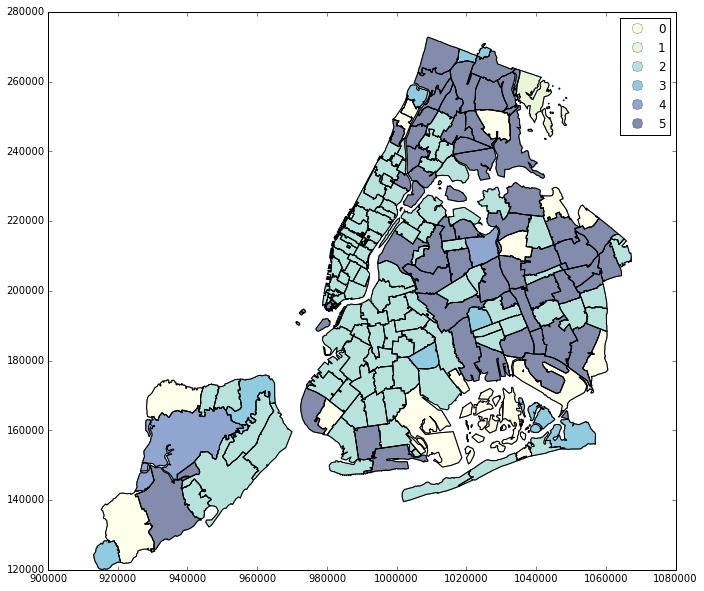

In [72]:
f = plt.figure(figsize=(15,10))
km_gdf.plot(column ='label',categorical=True,legend=True,colormap='YlGnBu')

## Comment: 
- There is no significant pattern in clustering result.  Air quality maybe is a good guess.

##DISCUSS 
- most of discussion are attached below their code.
- However, I would like to point out that we need find other feature to train our model, or choose more observations. I think 5 observations are not good enough to do this project.

## Extra : More observations (full zipcodes)

In [73]:
zip_fad11.columns = ['zipcode','count']
ex_ob = pd.merge(dataset,zip_fad11)
ex_ob = pd.merge(ex_ob,indoor)

In [74]:
ex_ob.head()

,geometry,highway_length,re_area,zipcode,count,indoor_rate
0,"(POLYGON ((954812.9817938869 173205.956084427,...",0.000000,339.638529,10310,404,0.027473
1,"(POLYGON ((1002515.19766016 191891.2358232759,...",1.416299,149.332679,11206,486,0.083333
2,(POLYGON ((990508.4373542365 220369.6933363593...,2.108747,32.435151,10019,289,0.213213
3,(POLYGON ((997702.9518395039 221099.0967237492...,4.232831,174.179979,10021,236,0.203791
4,(POLYGON ((997702.9518395039 221099.0967237492...,4.232831,174.179979,10021,20,0.203791


In [75]:
mod3 = smf.ols(formula='count ~ highway_length + re_area + indoor_rate', data = ex_ob).fit()
mod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.6408
Date:                Tue, 22 Dec 2015   Prob (F-statistic):              0.593
Time:                        22:44:15   Log-Likelihood:                -343.58
No. Observations:                  47   AIC:                             695.2
Df Residuals:                      43   BIC:                             702.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept        341.1961    160.480      2.126      0.039        17.558   664.834
highway_length    14.5741     10.644      1.369      0.178        -6.892    36.040
re_area           -0.0119      0.034     -0.351      0.727        -0.080     0.057
indoor_rate      328.8848    903.270      0.364      0.718     -1492.732  2150.502
==============================================================================
Omnibus:                       28.772   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.370
Skew:                           1.796   Prob(JB):                     5.75e-13
Kurtosis:                       6.985   Cond. No.                     3.31e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# After add more observation, the result is still not good enough to interpret asthma risk. We need more reasonable features to do this regression.